In [22]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns

#### Reproduce stuff from the articale

<Axes: xlabel='Date'>

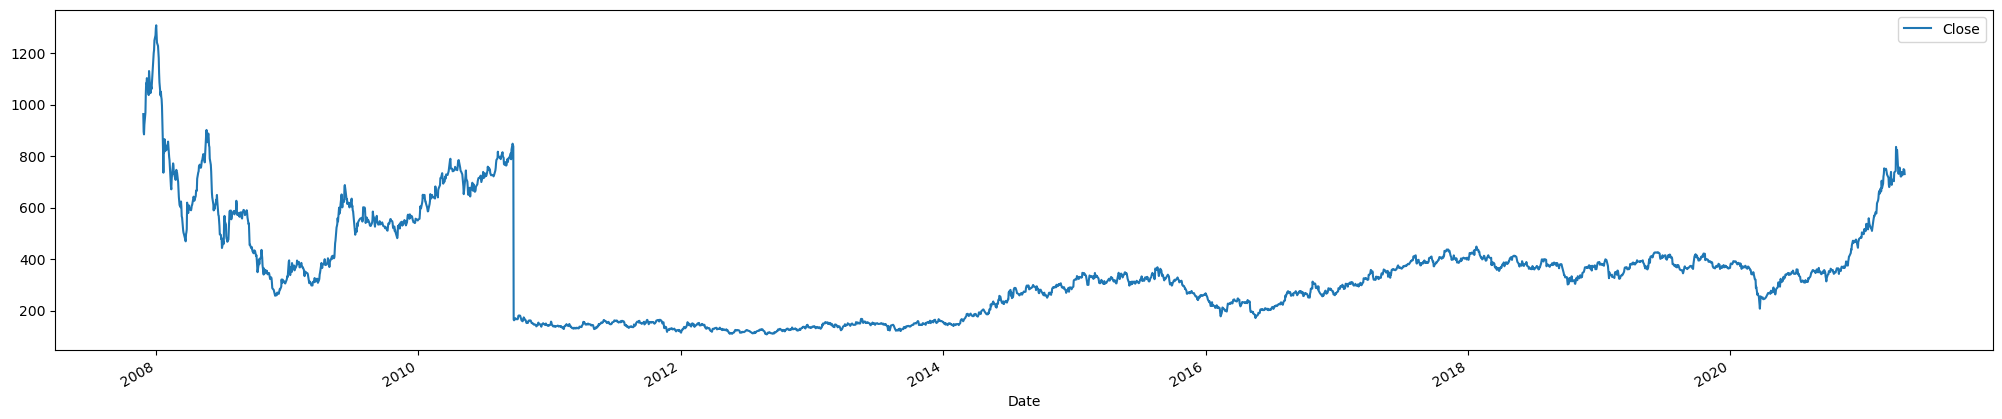

In [32]:
nifty = pd.read_csv('D:\\nifty.csv',
                     usecols=['Date', "Close"],
                     parse_dates=['Date'])

nifty.set_index("Date", inplace=True) #setting "Date" as index
nifty.asfreq("b", method='ffill') #setting frequency to business days

nifty.plot(figsize=(25,5))

In [33]:
nifty.head(3)

,Close
Date,
2007-11-27,962.9
2007-11-28,893.9
2007-11-29,884.2


In [5]:
def my_auto_corr(df, nlags=2):
    '''
    Returns autocorrelation coefficient for lags [nlags, 0]
    
    df: dataframe
        Input dataframe of time series
    nlags: int
           maximum number of lags, default 2
    
    Returns
    array: autocorrelation coefficients for lags [nlags, 0]
    '''
    def autocorr(y, lag=2):
        '''
        Calculates autocorrelation coefficient for single lag value
        
        y: array
           Input time series array
        lag: int, default: 2 
             'kth' lag value
        
        Returns
        int: autocorrelation coefficient 
        '''
        y = np.array(y).copy()
        y_bar = np.mean(y) #y_bar = mean of the time series y
        denominator = sum((y - y_bar) ** 2) #sum of squared differences between y(t) and y_bar
        numerator_p1 = y[lag:] - y_bar #y(t)-y_bar: difference between time series (from 'lag' till the end) and y_bar
        numerator_p2 = y[:-lag] - y_bar #y(t-k)-y_bar: difference between time series (from the start till lag) and y_bar
        numerator = sum(numerator_p1 * numerator_p2) #sum of y(t)-y_bar and y(t-k)-y_bar
        return (numerator / denominator)
    
    acf = [1] #initializing list with autocorrelation coefficient for lag k=0 which is always 1
    for i in range(1, (nlags + 1)):
        acf.append(autocorr(df.iloc[:, 0].values, lag=i)) #calling autocorr function for each lag 'i'
    return np.array(acf)

In [24]:
acf_my = my_auto_corr(df=nifty, nlags=10)
acf_statsmodels = tsaplots.acf(nifty.iloc[:,0].values,nlags=10)

# this is what I use
acf_statstools = acf(nifty.iloc[:,0].values,nlags=10)

print(f'my_auto_corr:\n{acf_my}\n\nstatsmodels acf:\n{acf_statsmodels}\n\nstatstools acf:\n{acf_statstools}')

my_auto_corr:
[1.         0.99441697 0.98887259 0.9832766  0.9774236  0.97172373
 0.96558168 0.95912641 0.95266118 0.94611799 0.9398013 ]

statsmodels acf:
[1.         0.99441697 0.98887259 0.9832766  0.9774236  0.97172373
 0.96558168 0.95912641 0.95266118 0.94611799 0.9398013 ]

statstools acf:
[1.         0.99441697 0.98887259 0.9832766  0.9774236  0.97172373
 0.96558168 0.95912641 0.95266118 0.94611799 0.9398013 ]


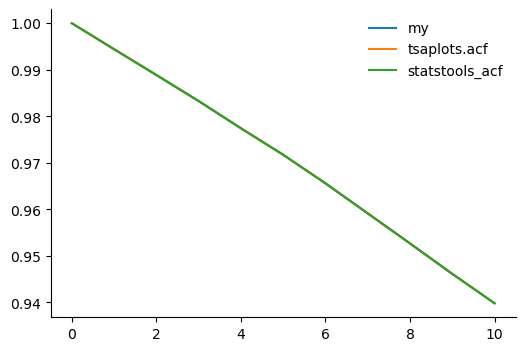

In [25]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my, label='my')
axes.plot(t_lags, acf_statsmodels, label='tsaplots.acf')
axes.plot(t_lags, acf_statstools, label='statstools_acf')

axes.legend(frameon=False)

sns.despine()

#### Step by step calc with short sequence

In [50]:
def autocorr_verbose(y, lag=2, verbose=True):
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag, y.shape))
    y = np.array(y).copy()
    y_bar = np.mean(y)
    denominator = sum((y - y_bar) ** 2) 
    if verbose:
        print('y_bar = {}, denominator = {}'.format(y_bar, denominator))
    numerator_p1 = y[lag:] - y_bar
    numerator_p2 = y[:-lag] - y_bar 
    if verbose:
        print('shape numerator_p1 {}, numerator_p2 {}'.format(numerator_p1.shape, numerator_p2.shape))
    numerator = sum(numerator_p1 * numerator_p2) 
    acf_lag = numerator / denominator
    if verbose:
        print('acf_lag {}'.format(acf_lag))
    return acf_lag

def my_auto_corr_verbose(time_series, nlags=2):
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(autocorr_verbose(time_series, lag=i)) 
    return np.array(acf)

##### Very short - 10 values and 10 lags

In [48]:
nifty_10 = nifty.iloc[:10, :].copy()
nifty_10_values = nifty_10.iloc[:, 0].values
nifty_10_values

array([ 962.9 ,  893.9 ,  884.2 ,  921.55,  969.3 , 1041.45, 1082.45,
       1081.3 , 1102.4 , 1075.4 ])

In [45]:
autocorr_verbose(nifty_10_values, lag=1, verbose=True)

Calc for lag 1, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (9,), numerator_p2 (9,)
acf_lag 0.817242668797377


0.817242668797377

In [47]:
acf_my_short = my_auto_corr_verbose(nifty_10_values, nlags=10)

Calc for lag 1, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (9,), numerator_p2 (9,)
acf_lag 0.817242668797377
Calc for lag 2, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (8,), numerator_p2 (8,)
acf_lag 0.4402639468875911
Calc for lag 3, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (7,), numerator_p2 (7,)
acf_lag 0.04403386183739792
Calc for lag 4, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (6,), numerator_p2 (6,)
acf_lag -0.29849817274761165
Calc for lag 5, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (5,), numerator_p2 (5,)
acf_lag -0.46665298981820785
Calc for lag 6, input length (10,)
y_bar = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (4,), numerator_p2 (4,)
acf_lag -0.457272794863756
Calc for lag 7, input length (10,)
y_bar = 1001.485, denominator =

In [54]:
acf_statsmodels_short = tsaplots.acf(nifty_10_values,nlags=10)

# this is what I use
acf_statstools_short = acf(nifty_10_values,nlags=10)

print(f'my_auto_corr:\n{acf_my_short}\n\nstatsmodels acf:\n{acf_statsmodels_short}\n\nstatstools acf:\n{acf_statstools_short}')

my_auto_corr:
[ 1.          0.81724267  0.44026395  0.04403386 -0.29849817 -0.46665299
 -0.45727279 -0.35093981 -0.18390103 -0.04427569  0.        ]

statsmodels acf:
[ 1.          0.81724267  0.44026395  0.04403386 -0.29849817 -0.46665299
 -0.45727279 -0.35093981 -0.18390103 -0.04427569]

statstools acf:
[ 1.          0.81724267  0.44026395  0.04403386 -0.29849817 -0.46665299
 -0.45727279 -0.35093981 -0.18390103 -0.04427569]


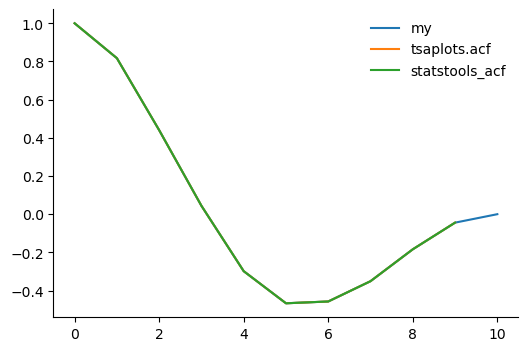

In [56]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my_short, label='my')
axes.plot(t_lags[:-1], acf_statsmodels_short, label='tsaplots.acf')
axes.plot(t_lags[:-1], acf_statstools_short, label='statstools_acf')

axes.legend(frameon=False)

sns.despine()

##### A bit longer

In [57]:
nifty_100 = nifty.iloc[:100, :].copy()
nifty_100_values = nifty_100.iloc[:, 0].values
nifty_100_values

array([ 962.9 ,  893.9 ,  884.2 ,  921.55,  969.3 , 1041.45, 1082.45,
       1081.3 , 1102.4 , 1075.4 , 1047.65, 1036.8 , 1129.95, 1110.5 ,
       1044.25, 1074.95, 1066.9 , 1060.2 , 1156.8 , 1199.9 , 1211.65,
       1249.1 , 1268.8 , 1296.85, 1307.45, 1275.8 , 1240.35, 1227.25,
       1204.8 , 1180.25, 1121.55, 1085.85, 1035.15, 1049.55, 1030.4 ,
       1020.9 ,  994.6 ,  825.05,  735.55,  857.  ,  814.15,  865.7 ,
        820.8 ,  840.75,  830.45,  837.65,  825.35,  856.1 ,  834.3 ,
        807.5 ,  796.25,  784.05,  711.2 ,  681.3 ,  670.95,  709.8 ,
        728.75,  771.6 ,  763.9 ,  732.1 ,  737.6 ,  724.  ,  707.65,
        735.8 ,  746.4 ,  737.75,  735.65,  699.25,  669.25,  640.9 ,
        609.75,  601.15,  623.7 ,  602.9 ,  566.3 ,  561.  ,  511.45,
        502.4 ,  497.75,  469.2 ,  497.15,  504.05,  516.  ,  619.2 ,
        578.75,  592.2 ,  608.35,  602.3 ,  593.2 ,  593.4 ,  589.65,
        597.75,  608.6 ,  610.2 ,  642.55,  637.4 ,  626.35,  645.15,
        665.85,  666

In [58]:
acf_my_short100 = my_auto_corr_verbose(nifty_100_values, nlags=10)

Calc for lag 1, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (99,), numerator_p2 (99,)
acf_lag 0.9809900613145005
Calc for lag 2, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (98,), numerator_p2 (98,)
acf_lag 0.9597172505600458
Calc for lag 3, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (97,), numerator_p2 (97,)
acf_lag 0.9371789931367166
Calc for lag 4, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (96,), numerator_p2 (96,)
acf_lag 0.9105830073078439
Calc for lag 5, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (95,), numerator_p2 (95,)
acf_lag 0.8853613635644678
Calc for lag 6, input length (100,)
y_bar = 835.1795, denominator = 5321324.055475001
shape numerator_p1 (94,), numerator_p2 (94,)
acf_lag 0.8590879041279191
Calc for lag 7, input length (100,)
y_bar = 835.1795

In [59]:
acf_statsmodels_short100 = tsaplots.acf(nifty_100_values,nlags=10)

# this is what I use
acf_statstools_short100 = acf(nifty_100_values,nlags=10)

print(f'my_auto_corr:\n{acf_my_short100}\n\nstatsmodels acf:\n{acf_statsmodels_short100}\n\nstatstools acf:\n{acf_statstools_short100}')

my_auto_corr:
[1.         0.98099006 0.95971725 0.93717899 0.91058301 0.88536136
 0.8590879  0.82588842 0.79299606 0.75682749 0.72286365]

statsmodels acf:
[1.         0.98099006 0.95971725 0.93717899 0.91058301 0.88536136
 0.8590879  0.82588842 0.79299606 0.75682749 0.72286365]

statstools acf:
[1.         0.98099006 0.95971725 0.93717899 0.91058301 0.88536136
 0.8590879  0.82588842 0.79299606 0.75682749 0.72286365]


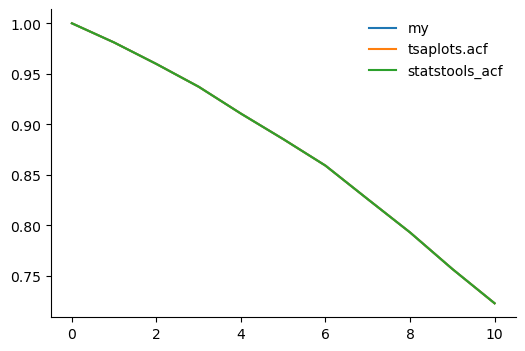

In [61]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my_short100, label='my')
axes.plot(t_lags, acf_statsmodels_short100, label='tsaplots.acf')
axes.plot(t_lags, acf_statstools_short100, label='statstools_acf')

axes.legend(frameon=False)

sns.despine()

#### Plot acf on full, on 10 and on 100

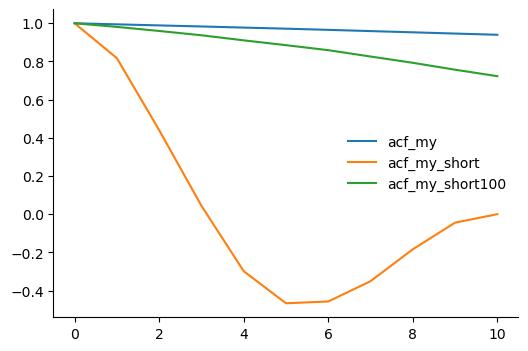

In [62]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my, label='acf_my')
axes.plot(t_lags, acf_my_short, label='acf_my_short')
axes.plot(t_lags, acf_my_short100, label='acf_my_short100')

axes.legend(frameon=False)

sns.despine()